<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Examples/blob/master/notebooks/nsclc-radiomics/nsclc_radiomics_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Rationale </center> 

This notebook showcases a demo for Hosny et Al. [Deep learning for lung cancer prognostication: A retrospective multi-cohort radiomics study](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002711), reproduced using the tools provided by the Imaging Data Commons.


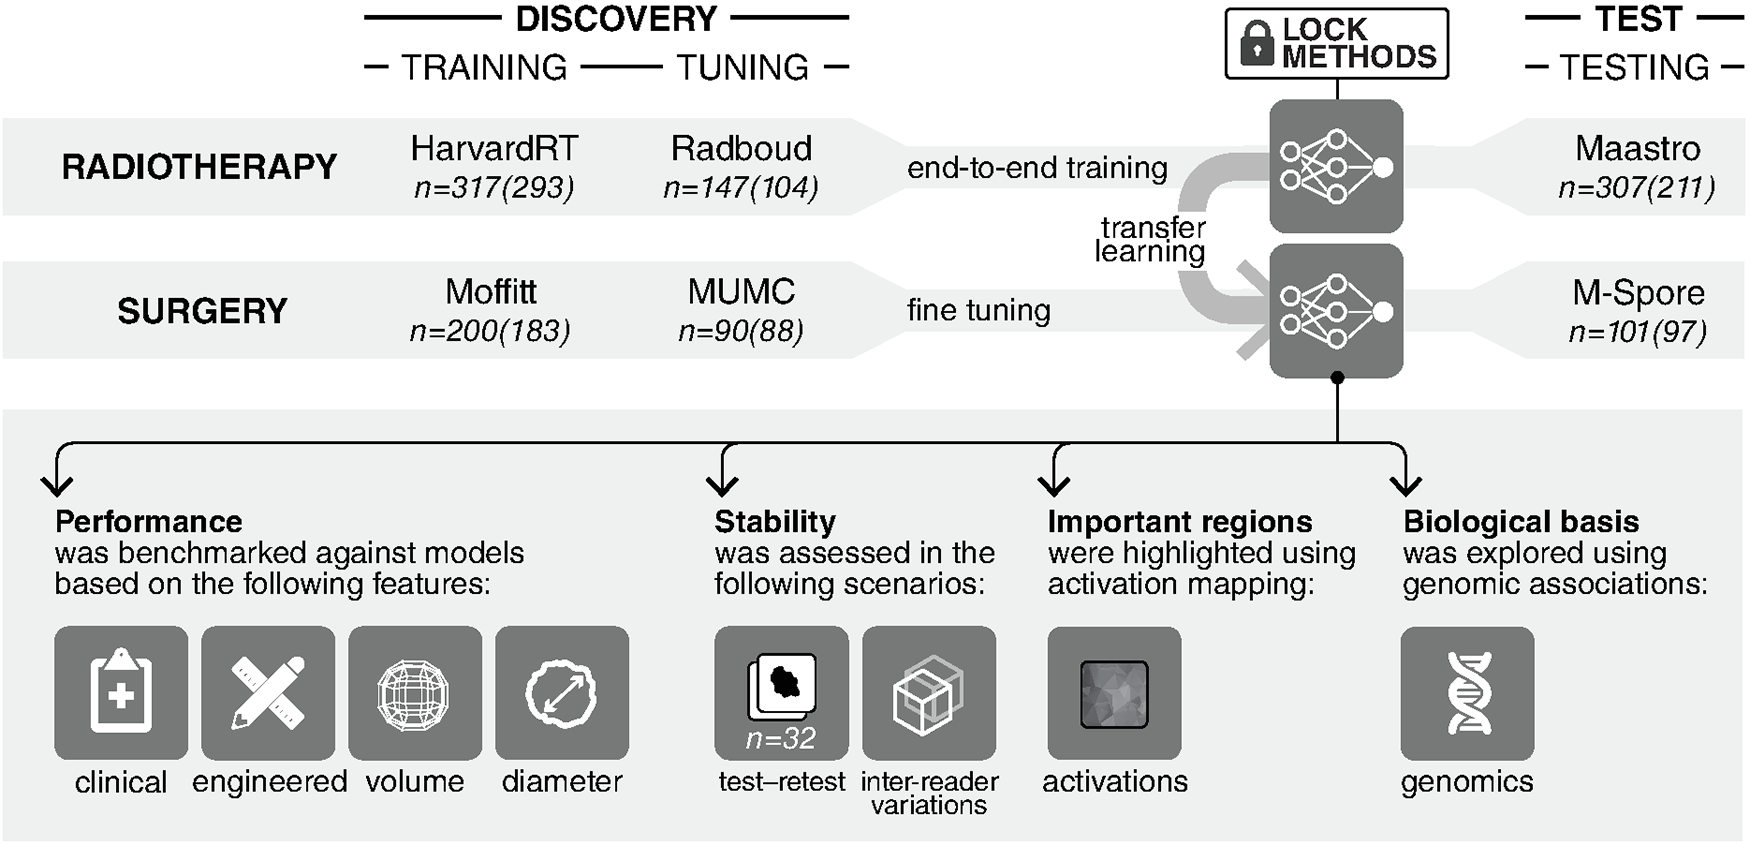

The goal of this notebook is to provide the user with an example of how the tools provided by the Imaging Data Commons could be used to run an AI/ML end-to-end analysis on a cohort hosted by the portal, and to describe what we identified as the best practices to do so.

<br>

For additional details and notes regarding the replication, please see [the GitHub page of this demo](https://github.com/ImagingDataCommons/IDC-Examples/tree/master/notebooks/nsclc-radiomics).

---
---

# <center> Environment Setup, Data Download and Pre-processing </center>

In [1]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /content
Hostname          : 04d28fdde8d5
Username          : root


## Environment Set Up

This demo notebook is intended to be run using a GPU.

To access a free GPU on Colab:
`Edit > Notebooks Settings`

From the dropdown menu under `Hardware accelerator`, select `GPU`.

In [2]:
# check wether the use of a GPU was correctly enabled
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "failed" in gpu_list[0] else True

has_gpu

True


Since we are interested in cloning only a subdirectory of the repository, and the git CLI does not allow that, we can use either [GitHub's CLI](https://cli.github.com/manual/) `gh` (requires authentication) or Apache's subversion `svn` [[1]](https://cheatography.com/davechild/cheat-sheets/subversion/) [[2]](https://stackoverflow.com/questions/7106012/download-a-single-folder-or-directory-from-a-github-repo):

In [3]:
%%capture
!sudo apt install subversion

In [4]:
!rm -r sample_data
!svn checkout https://github.com/ImagingDataCommons/IDC-Examples/trunk/notebooks/nsclc-radiomics/demo
!svn checkout https://github.com/modelhub-ai/deep-prognosis/trunk/contrib_src/sample_data
!mv sample_data hosny_sample_data

rm: cannot remove 'sample_data': No such file or directory
Checked out revision 49.
A    sample_data/LUNG1-002.npy
A    sample_data/LUNG1-004.npy
A    sample_data/LUNG1-006.npy
Checked out revision 22.


In [5]:
!pip3 install -r demo/requirements.txt

For image pre-processing we will use [Plastimatch](https://plastimatch.org), a reliable and open source software for image computation.

Plastimatch is available as an extension (plug-in) for 3D Slicer, but can also be used from the command line/from python scripts (using libraries such as `subprocess`):

In [6]:
%%capture
!sudo apt update
!sudo apt install plastimatch

To verify the installation process was successful, check Plastimatch version:

In [7]:
!plastimatch --version

plastimatch version 1.7.0


---

In [8]:
import os
import sys
import json
import random
import sklearn 
import numpy as np
import pandas as pd
import SimpleITK as sitk

from IPython.display import clear_output

%tensorflow_version 1.x
import tensorflow as tf
import keras

from demo.data_utils import *
from demo.utils import *

print("Python version               : ", sys.version.split('\n')[0])
print("Numpy version                : ", np.__version__)
print("TensorFlow version           : ", tf.__version__)
print("Keras (stand-alone) version  : ", keras.__version__)

print("\nThis Colab instance is equipped with a GPU.")

# ----------------------------------------

#everything that has to do with plotting goes here below

import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a \"color overlay\" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.jet
my_jet = cmap(np.arange(cmap.N))
my_jet[:,-1] = np.linspace(0, 1, cmap.N)
my_jet = ListedColormap(my_jet)

## ----------------------------------------

import seaborn as sns

TensorFlow 1.x selected.
Python version               :  3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy version                :  1.18.5
TensorFlow version           :  1.15.2
Keras (stand-alone) version  :  2.3.1

This Colab instance is equipped with a GPU.


Using TensorFlow backend.


---

## Data Download

The Imaging Data Commons GCS buckets are "[requester pays](https://cloud.google.com/storage/docs/requester-pays)" buckets. Hence, it is not possible to [mount such buckets directly in Colab](https://gist.github.com/korakot/f3600576720206363c734eca5f302e38).

Instead, what the user can do is to query the BigQuery table associated to the bucket/dataset, select the cohort of interest, and then download the files exploiting `gsutil`.

<font size="5" color="orange"><b>This step (auth) won't be needed once the IDC bucket goes live</b></font>

In [9]:
from google.colab import auth
auth.authenticate_user()

---
#### Exploiting BigQuery to Select which Data to Download

In order to parse information regarding the dataset of interest (e.g., which subjects to download, the mapping between DICOM CTs and DICOM RTSTRUCTs/RTSEGs, ...), the user can run a BigQuery query, exploiting the `%%bigquery` [IPython Magic](https://googleapis.dev/python/bigquery/latest/magics.html) as seen in the example provided as part of the [IDC LIDC Exploration Notebook](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/LIDC_exploration.ipynb).

Using the following syntax, the result will be stored as a DataFrame in `cohort_df`.

In [10]:
%%bigquery --project=idc-sandbox-000 cohort_df

WITH
  ct_series AS (
  SELECT
    DISTINCT(PatientID),
    StudyInstanceUID AS ctStudyInstanceUID,
    SeriesInstanceUID AS ctSeriesInstanceUID
  FROM
    `idc-dev-etl.idc_tcia.idc_tcia`
  WHERE
    PatientID LIKE "LUNG1%"
    AND Modality = "CT"
  ORDER BY
    PatientID),
  rtstruct_series AS (
  SELECT
    DISTINCT(PatientID),
    StudyInstanceUID AS rtstructStudyInstanceUID,
    SeriesInstanceUID AS rtstructSeriesInstanceUID
  FROM
    `idc-dev-etl.idc_tcia.idc_tcia`
  WHERE
    PatientID LIKE "LUNG1%"
    AND Modality = "RTSTRUCT"
  ORDER BY
    PatientID),
  seg_series AS (
  SELECT
    DISTINCT(PatientID),
    StudyInstanceUID AS segStudyInstanceUID,
    SeriesInstanceUID AS segSeriesInstanceUID
  FROM
    `idc-dev-etl.idc_tcia.idc_tcia`
  WHERE
    PatientID LIKE "LUNG1%"
    AND Modality = "SEG"
  ORDER BY
    PatientID)
SELECT
  PatientID,
  ctStudyInstanceUID,
  ctSeriesInstanceUID,
  rtstructStudyInstanceUID,
  rtstructSeriesInstanceUID,
  segStudyInstanceUID,
  segSeriesInstanceUID
FROM
  ct_series
JOIN
  rtstruct_series
using (PatientID)
JOIN
  seg_series
USING
  (PatientID)
ORDER BY
  PatientID

In [11]:
cohort_df.head()

,PatientID,ctStudyInstanceUID,ctSeriesInstanceUID,rtstructStudyInstanceUID,rtstructSeriesInstanceUID,segStudyInstanceUID,segSeriesInstanceUID
0,LUNG1-001,1.3.6.1.4.1.32722.99.99.2393413539117143687725...,1.3.6.1.4.1.32722.99.99.2989917765213423750108...,1.3.6.1.4.1.40744.29.2393413539117143687725971...,1.3.6.1.4.1.40744.29.2279381215866080725084441...,1.3.6.1.4.1.40744.29.2393413539117143687725971...,1.2.276.0.7230010.3.1.3.8323329.16296.15548365...
1,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.3.6.1.4.1.40744.29.2037150038059966416957653...,1.3.6.1.4.1.40744.29.2432675512669112458302594...,1.3.6.1.4.1.40744.29.2037150038059966416957653...,1.2.276.0.7230010.3.1.3.8323329.21133.15548295...
2,LUNG1-003,1.3.6.1.4.1.32722.99.99.2477262867958601216867...,1.3.6.1.4.1.32722.99.99.2389222799296192439904...,1.3.6.1.4.1.40744.29.2477262867958601216867965...,1.3.6.1.4.1.40744.29.2175894477461117410564218...,1.3.6.1.4.1.40744.29.2477262867958601216867965...,1.2.276.0.7230010.3.1.3.8323329.20958.15548278...
3,LUNG1-004,1.3.6.1.4.1.32722.99.99.2026036697036260886779...,1.3.6.1.4.1.32722.99.99.2809816144625926346520...,1.3.6.1.4.1.40744.29.2026036697036260886779831...,1.3.6.1.4.1.40744.29.1989243449739101957480841...,1.3.6.1.4.1.40744.29.2026036697036260886779831...,1.2.276.0.7230010.3.1.3.8323329.31481.15548267...
4,LUNG1-005,1.3.6.1.4.1.32722.99.99.7196186628043392557101...,1.3.6.1.4.1.32722.99.99.3490584753983772067630...,1.3.6.1.4.1.40744.29.7196186628043392557101987...,1.3.6.1.4.1.40744.29.1186162681418618501244963...,1.3.6.1.4.1.40744.29.7196186628043392557101987...,1.2.276.0.7230010.3.1.3.8323329.7097.155482712...


After selecting a few subjects from the cohort, exploiting the output of the BigQuery query, populate a dictionary with the `ctStudyInstanceUID` and `rtstructStudyInstanceUID` values.

Finally, exploit `gsutil` to download such sub-cohort (as instructed in the [IDC Cohort Download Notebook](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/Cohort_download.ipynb)):

In [12]:
# while the download is quite fast, the preprocessing of each subject takes
# from 30 to 60 seconds - so select n_patients carefully!
n_patients = 25

# useful for logging purposes
download_dict = dict()

# since gsutil can be called with "-m" providing a list as an input,
# append each gs URI to download to a list:
to_download = list()
base_gs_uri = 'gs://idc-tcia-1-nsclc-radiomics/dicom/'

# analysis baseline: Hosny et Al. results
baseline_csv_name = 'nsclc-radiomics_hosny_baseline.csv'
baseline_csv_path = os.path.join('demo', baseline_csv_name)
baseline_df = pd.read_csv(baseline_csv_path)

# make sure the selected sub-cohort was analysed in full by Hosny et Al. 
#subcohort_df = cohort_df.sample(n = n_patients)

# list of the NSCLC-Radiomics subjects analysed in Hosny et Al.
baseline_subj_list = [a[1:] for a in list(baseline_df["id"].dropna())]

# intersection between the two sets
common_subj_list = list(set(baseline_subj_list) & set(cohort_df["PatientID"]))

# sanity check
assert len(baseline_subj_list) == len(common_subj_list)

# patients to download
selected_subj_list = random.sample(common_subj_list, n_patients)

# for visualisation/comparison purposes, include one of the patients found
# in Hosny et Al. released sample data (./hosny_sample_data)
comp_sample_subj = 'LUNG1-002'
if comp_sample_subj not in selected_subj_list:
  selected_subj_list[-1] = (comp_sample_subj)

# populate a dataset with the selected n_patients
subcohort_df = cohort_df[cohort_df["PatientID"].isin(selected_subj_list)]

for pat_num, pat in enumerate(list(subcohort_df["PatientID"])):
  print("(%g/%g) - PatientID: %s"%(pat_num + 1, n_patients, pat), end = '\r')

  pat_df = subcohort_df[subcohort_df["PatientID"] == pat]
  download_dict[pat] = dict()
  download_dict[pat]["ctStudyInstanceUID"] = pat_df["ctStudyInstanceUID"].values[0]
  download_dict[pat]["rtstructStudyInstanceUID"] = pat_df["rtstructStudyInstanceUID"].values[0]

  to_download.append(base_gs_uri + download_dict[pat]["ctStudyInstanceUID"])
  to_download.append(base_gs_uri + download_dict[pat]["rtstructStudyInstanceUID"])

In [13]:
subcohort_df.head()

,PatientID,ctStudyInstanceUID,ctSeriesInstanceUID,rtstructStudyInstanceUID,rtstructSeriesInstanceUID,segStudyInstanceUID,segSeriesInstanceUID
1,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.3.6.1.4.1.40744.29.2037150038059966416957653...,1.3.6.1.4.1.40744.29.2432675512669112458302594...,1.3.6.1.4.1.40744.29.2037150038059966416957653...,1.2.276.0.7230010.3.1.3.8323329.21133.15548295...
37,LUNG1-038,1.3.6.1.4.1.32722.99.99.2475020851376675459335...,1.3.6.1.4.1.32722.99.99.2650234890770352701645...,1.3.6.1.4.1.40744.29.2475020851376675459335996...,1.3.6.1.4.1.40744.29.1878428656637439964988662...,1.3.6.1.4.1.40744.29.2475020851376675459335996...,1.2.276.0.7230010.3.1.3.8323329.30976.15548301...
54,LUNG1-055,1.3.6.1.4.1.32722.99.99.2284792753098082964616...,1.3.6.1.4.1.32722.99.99.5212730671773885988249...,1.3.6.1.4.1.40744.29.2284792753098082964616271...,1.3.6.1.4.1.40744.29.2203808798590393720861702...,1.3.6.1.4.1.40744.29.2284792753098082964616271...,1.2.276.0.7230010.3.1.3.8323329.10524.15548362...
76,LUNG1-077,1.3.6.1.4.1.32722.99.99.3021236059167307643539...,1.3.6.1.4.1.32722.99.99.2008814152555682954343...,1.3.6.1.4.1.40744.29.3021236059167307643539339...,1.3.6.1.4.1.40744.29.8007440293870274493922761...,1.3.6.1.4.1.40744.29.3021236059167307643539339...,1.2.276.0.7230010.3.1.3.8323329.16452.15548241...
77,LUNG1-078,1.3.6.1.4.1.32722.99.99.1979963770295813468388...,1.3.6.1.4.1.32722.99.99.2086535154487063707444...,1.3.6.1.4.1.40744.29.1979963770295813468388920...,1.3.6.1.4.1.40744.29.1816843003193922537050254...,1.3.6.1.4.1.40744.29.1979963770295813468388920...,1.2.276.0.7230010.3.1.3.8323329.24818.15548352...


In [14]:
# populate a dataframe with such gs URI (again, mostly for logging purposes)
manifesto_dict = {"gs_uri" : to_download}
manifesto_df = pd.DataFrame(manifesto_dict, columns = ["gs_uri"])

manifesto_df.head()

,gs_uri
0,gs://idc-tcia-1-nsclc-radiomics/dicom/1.3.6.1....
1,gs://idc-tcia-1-nsclc-radiomics/dicom/1.3.6.1....
2,gs://idc-tcia-1-nsclc-radiomics/dicom/1.3.6.1....
3,gs://idc-tcia-1-nsclc-radiomics/dicom/1.3.6.1....
4,gs://idc-tcia-1-nsclc-radiomics/dicom/1.3.6.1....


In [15]:
# generate a text file, which will be parsed by gsutil to download the selected patients:
manifesto_df.to_csv("gcs_paths.txt", header = False, index = False)

# check everything went as expected
!head /content/gcs_paths.txt -n 2
!echo "..." && echo ""

# the number of lines in the file should be equal to twice the specified "n_patients"
!echo "Number of lines in the file:" $(cat /content/gcs_paths.txt | wc -l)

gs://idc-tcia-1-nsclc-radiomics/dicom/1.3.6.1.4.1.32722.99.99.203715003805996641695765332389135385095
gs://idc-tcia-1-nsclc-radiomics/dicom/1.3.6.1.4.1.40744.29.203715003805996641695765332389135385095
...

Number of lines in the file: 50


---

#### DICOM Data Download

The following instructions will download the DICOM CT and DICOM RTSTRUCT files for `n_patients` patients. For `n_patients = 10`, the download should take approximately 3-4 minutes (roughly 1-1.5k files, a total of 500-700MB).

In [16]:
%%capture
# if everything is allright, proceed with the download
!mkdir -p data/nsclc-radiomics/dicom

!cat gcs_paths.txt | gsutil -u idc-sandbox-000 -m cp -Ir ./data/nsclc-radiomics/dicom

---

Check the disk space after the download:

In [17]:
# storage-wise, the analysis of Hosny et Al. cohort (211 patients) should be
# possible (as 25 patients occupy roughly 1.7GB in size)
!df -h | grep /dev/sda1 
!du -h ./data/nsclc-radiomics -d 0

/dev/sda1        75G   38G   37G  51% /opt/bin
3.2G	./data/nsclc-radiomics



---

## Data Pre-processing

Let us exploit the python scripts under `demo` to preprocess the data:

* First of all, each DICOM Series (CT and RTSTRUCT) is converted from DICOM to NRRD using plastimatch. Following the authors pipeline, we then resample all the volumes to 1-mm isotropic:
  * In this case, the interpolation step uses a linear strategy but, as we will investigate later, the model is robust to the textural differences introduced by a different interpolation strategy, such as a nearest neighbour one);
  * A .png image is exported for quality control, together with other potentially useful information, and can be found in the patient folder (under `nsclc-radiomics_preprocessed`);
* After the conversion and the resampling, other application-specific transformations are applied to the data. The main tumour Center of Mass (CoM) is computed starting from the labelled GTV, and a $150 \times 150 \times 150$ subvolume is cropped around such coordinate.

<br>

In order to save space on the Colab instance partition, only the final $150 \times 150 \times 150$ subvolumes (both CT and the GTV segmentation mask, saved in NRRD) are kept. 

All the informations regarding the crop, the list of segmentation masks found in the RTSTRUCT, and the CoM - together with the aforementioned quality-control pngs, are saved under the patient folder in the following fashion:

```
data
    |_nsclc-radiomics_preprocessed
                                  |_nrrd
                                        |_LUNG1-XYZ
                                                   |_LUNG1-XYZ_whole_ct_rt
                                                   |_LUNG1-XYZ_com_log.json
                                                   |_LUNG1-XYZ_lookup_info.json
                                                   ...
```

In [18]:
data_base_path = 'data'

dataset_name = 'nsclc-radiomics'
dataset_path = os.path.join(data_base_path, dataset_name)
data_path = os.path.join(dataset_path, 'dicom')

preproc_dataset_name = dataset_name + '_preprocessed'
preproc_dataset_path = os.path.join(data_base_path, preproc_dataset_name)
preproc_data_path = os.path.join(preproc_dataset_path, 'nrrd')

!mv ./hosny_sample_data data
sample_data_path = os.path.join(data_base_path, 'hosny_sample_data')

if not os.path.exists(preproc_data_path):
    os.makedirs(preproc_data_path)

mv: cannot move './hosny_sample_data' to 'data/hosny_sample_data': Directory not empty


Due to the nature of the operations involved (i.e., DICOM to NRRD conversion, resampling, cropping) the following step can take some time (roughly 30-60 seconds per patient).

In [19]:
for pat_num, pat in enumerate(subcohort_df.PatientID.values):

    # clear cell output before moving to the next (goes at the top to clean what comes next)
    clear_output(wait = True)
    
    print("\nPatient %d/%d (%s)"%(pat_num + 1, len(subcohort_df), pat))
    
    pat_dir_path = os.path.join(preproc_data_path, pat)
    
    if not os.path.exists(pat_dir_path):
        os.mkdir(pat_dir_path)
    
    # location where the tmp nrrd files (resampled CT/RTSTRUCT nrrd) should be saved
    # by the "export_res_nrrd_from_dicom" function found in preprocess.py
    ct_nrrd_path = os.path.join(pat_dir_path, pat + '_ct_resampled.nrrd')
    rt_nrrd_path = os.path.join(pat_dir_path, pat + '_rt_resampled.nrrd')

    # location where the nrrd files (cropped resampled CT/RTSTRUCT nrrd) should be saved
    # by the "export_com_subvolume" function found in preprocess.py
    ct_nrrd_crop_path = os.path.join(pat_dir_path, pat + '_ct_res_crop.nrrd')
    rt_nrrd_crop_path = os.path.join(pat_dir_path, pat + '_rt_res_crop.nrrd')
    
    # if the latter are already there, skip the processing
    if os.path.exists(ct_nrrd_crop_path) and os.path.exists(rt_nrrd_crop_path):
        print("%s\nand\n%s\nfound, skipping the processing for patient %s..."%(ct_nrrd_crop_path,
                                                                               rt_nrrd_crop_path, 
                                                                               pat))
        continue
    
    ## ----------------------------------------
    
    pat_df = subcohort_df[subcohort_df["PatientID"] == pat]


    path_to_ct_dir = os.path.join(data_path,
                                  pat_df["ctStudyInstanceUID"].values[0],
                                  pat_df["ctSeriesInstanceUID"].values[0])

    path_to_rt_dir = os.path.join(data_path,
                                  pat_df["rtstructStudyInstanceUID"].values[0],
                                  pat_df["rtstructSeriesInstanceUID"].values[0])

    path_to_seg_dir = os.path.join(data_path, 
                                   pat_df["segStudyInstanceUID"].values[0], 
                                   pat_df["segSeriesInstanceUID"].values[0])

    # sanity check
    assert os.path.exists(path_to_ct_dir)
    assert os.path.exists(path_to_rt_dir)
    assert os.path.exists(path_to_seg_dir)    
    
    # log lookup informations (human-readable to StudyUID and SeriesUID)
    lookup_dict_path = os.path.join(pat_dir_path, pat + '_lookup_info.json')
    
    lookup_dict = dict()
    lookup_dict[pat] = dict()
    
    lookup_dict[pat]["path_to_ct_dir"] = path_to_ct_dir
    lookup_dict[pat]["ctStudyInstanceUID"] = pat_df["ctStudyInstanceUID"].values[0]
    lookup_dict[pat]["ctSeriesInstanceUID"] = pat_df["ctSeriesInstanceUID"].values[0]
    
    lookup_dict[pat]["path_to_rt_dir"] = path_to_rt_dir
    lookup_dict[pat]["rtstructStudyInstanceUID"] = pat_df["rtstructStudyInstanceUID"].values[0]
    lookup_dict[pat]["rtstructSeriesInstanceUID"] = pat_df["rtstructSeriesInstanceUID"].values[0]
    
    lookup_dict[pat]["path_to_seg_dir"] = path_to_seg_dir
    lookup_dict[pat]["segStudyInstanceUID"] = pat_df["segStudyInstanceUID"].values[0]
    lookup_dict[pat]["segSeriesInstanceUID"] = pat_df["segSeriesInstanceUID"].values[0]
    
    with open(lookup_dict_path, 'w') as json_file:
        json.dump(lookup_dict, json_file, indent = 2)
    
    ## ----------------------------------------

    proc_log = export_res_nrrd_from_dicom(dicom_ct_path = path_to_ct_dir, 
                                          dicom_rt_path = path_to_rt_dir, 
                                          output_dir = pat_dir_path,
                                          ct_interpolation = 'linear',
                                          pat_id = pat,
                                          output_dtype = "float")
    
    # check every step of the DICOM to NRRD conversion returned 0 (everything's ok)
    assert(np.sum(np.array(list(proc_log.values()))) == 0)
    
    # sanity check
    assert(os.path.exists(ct_nrrd_path))
    assert(os.path.exists(rt_nrrd_path))
    
    sitk_vol = sitk.ReadImage(ct_nrrd_path)
    vol = sitk.GetArrayFromImage(sitk_vol)
    
    sitk_seg = sitk.ReadImage(rt_nrrd_path)
    seg = sitk.GetArrayFromImage(sitk_seg)
    
    # sanity check
    assert(vol.shape == seg.shape)
    
    com = compute_center_of_mass(seg)
    com_int = [int(coord) for coord in com]

    # export the CoM slice (CT + RTSTRUCT) for quality control
    export_png_slice(input_volume = vol,
                     input_segmask = seg,
                     fig_out_path = os.path.join(pat_dir_path, pat + '_whole_CT_CoM.png'),
                     fig_dpi = 220,
                     lon_slice_idx = com_int[0],
                     cor_slice_idx = com_int[1],
                     sag_slice_idx = com_int[2],
                     z_first = True)
    
    # crop a (150, 150, 150) subvolume from the resampled scans, get rid of the latter
    proc_log = export_com_subvolume(ct_nrrd_path = ct_nrrd_path, 
                                    rt_nrrd_path = rt_nrrd_path, 
                                    crop_size = (150, 150, 150), 
                                    output_dir = pat_dir_path,
                                    pat_id = pat,
                                    z_first = True, 
                                    rm_orig = True)
    
    # log CoM information
    com_log_path = os.path.join(pat_dir_path, pat + '_com_log.json')
    com_log_dict = {k : v for (k, v) in proc_log.items() if "com_int" in k}
    
    with open(com_log_path, 'w') as json_file:
        json.dump(com_log_dict, json_file, indent = 2)
    
    # if CoM calculation goes wrong then continue
    proc_log_crop = {k : v for (k, v) in proc_log.items() if "cropping" in k}
    if len(proc_log_crop) == 0:
        os.remove(ct_nrrd_path)
        os.remove(rt_nrrd_path)
        continue
    
    # check the cropped volumes have been exported as intended
    assert(np.sum(np.array(list(proc_log_crop.values()))) == 0)
    assert(os.path.exists(ct_nrrd_crop_path))
    assert(os.path.exists(rt_nrrd_crop_path))
    
    sitk_vol = sitk.ReadImage(ct_nrrd_crop_path)
    vol_crop = sitk.GetArrayFromImage(sitk_vol)

    sitk_seg = sitk.ReadImage(rt_nrrd_crop_path)
    seg_crop = sitk.GetArrayFromImage(sitk_seg)
    
    # export the cropped subvolume CoM slice (CT + RTSTRUCT) for quality control
    export_png_slice(input_volume = vol_crop,
                     input_segmask = seg_crop,
                     fig_out_path = os.path.join(pat_dir_path, pat + '_crop_CT_CoM.png'),
                     fig_dpi = 220,
                     lon_slice_idx = 75,
                     cor_slice_idx = 75,
                     sag_slice_idx = 75,
                     z_first = True)


Patient 25/25 (LUNG1-412)
Converting DICOM CT to NRRD using plastimatch... Done.
Converting DICOM RTSTRUCT to NRRD using plastimatch... Done.

Resampling NRRD CT to 1mm isotropic using plastimatch... Done.
Resampling NRRD RTSTRUCT to 1mm isotropic using plastimatch... Done.

Removing temporary files (DICOM to NRRD, non-resampled)... Done.

Exporting figure at: data/nsclc-radiomics_preprocessed/nrrd/LUNG1-412/LUNG1-412_whole_CT_CoM.png

Cropping the resampled NRRD CT to bbox using plastimatch... Done.
Cropping the resampled NRRD RTSTRUCT to bbox using plastimatch... Done.

Removing the resampled NRRD files... Done.

Exporting figure at: data/nsclc-radiomics_preprocessed/nrrd/LUNG1-412/LUNG1-412_crop_CT_CoM.png


---

### Logging All the Processing Details

In order to make sure the whole pipeline is easily reproducible, let's log all the details in `nsclc-radiomics_preprocessed/nscls-radiomics_preproc_details.csv`.

The CSV file contains information regarding:
* The patient ID;
* The relative paths to the folders containing DICOM CT, DICOM RTSTRUCT and DICOM RTSEG Series;
* The Study and Series Instance UID of all the Series;
* The shape of the original DICOM Series and the shape of the resampled to 1mm isotropic NRRD volumes;
* The name of the label used to compute the CoM (as stored in the DICOM RTSTRUCT Series, and thus exported by Plastimatch), the CoM (integer coordinates), the bounding box size and its coordinates in the resampled volume space.

In [20]:
csv_out_name = 'nsclc-radiomics_preproc_details.csv'
dataset_csv_path = os.path.join(data_base_path, csv_out_name)


df_keys = ['PatientID',
           'path_to_ct_dir', 'ctStudyInstanceUID', 'ctSeriesInstanceUID',
           'path_to_rt_dir', 'rtstructStudyInstanceUID', 'rtstructSeriesInstanceUID',
           'path_to_seg_dir', 'segStudyInstanceUID', 'segSeriesInstanceUID',
           'rt_exported', 'orig_shape', '1mm_iso_shape', 'crop_shape', 'com_int', 'bbox']

data = {k : list() for k in df_keys}

det_df = pd.DataFrame(data = data, dtype = object)

In [21]:
for pat_num, pat in enumerate(subcohort_df.PatientID.values):

    print("\rProcessing patient '%s' (%d/%d)... "%(pat, pat_num + 1,
                                                   len(subcohort_df.PatientID)),
          end = '')
    
    pat_df = subcohort_df[subcohort_df['PatientID'] == pat]
            
    # init a dictionary with the same keys as "df_keys" to populate the latter
    pat_dict = dict()
    pat_dict["PatientID"] = pat

    pat_dir_path = os.path.join(preproc_data_path, pat)
    pat_json_path = os.path.join(pat_dir_path, pat + '_lookup_info.json')

    with open(pat_json_path, 'r') as json_file:
        lookup_dict = json.load(json_file)
    
    pat_dict["path_to_ct_dir"] = lookup_dict[pat]["path_to_ct_dir"]
    pat_dict["ctStudyInstanceUID"] = pat_df['ctStudyInstanceUID'].values[0]
    pat_dict["ctSeriesInstanceUID"] = pat_df['ctSeriesInstanceUID'].values[0]

    pat_dict["path_to_rt_dir"] = lookup_dict[pat]["path_to_rt_dir"]
    pat_dict["rtstructStudyInstanceUID"] = pat_df['rtstructStudyInstanceUID'].values[0]
    pat_dict["rtstructSeriesInstanceUID"] = pat_df['rtstructSeriesInstanceUID'].values[0]

    pat_dict["path_to_seg_dir"] = lookup_dict[pat]["path_to_seg_dir"]
    pat_dict["segStudyInstanceUID"] = pat_df['segStudyInstanceUID'].values[0]
    pat_dict["segSeriesInstanceUID"] = pat_df['segSeriesInstanceUID'].values[0]
    
    # ----------------------------------------
    
    # populate the "rt_exported" field
    rt_folder = os.path.join(pat_dir_path, pat  + '_whole_ct_rt')
    pat_dict['rt_exported'] = [f for f in os.listdir(rt_folder) if 'gtv-1' in f.lower()][0].split('.nrrd')[0]   
    if pat_dict['rt_exported'] != 'GTV-1':
        a.append(pat)
    
    # ----------------------------------------
    
    dicom_ct_path = lookup_dict[pat]["path_to_ct_dir"]
    
    dcm_file_path = os.path.join(dicom_ct_path,                 # parent folder
                                 os.listdir(dicom_ct_path)[0])  # *.dcm files

    dcm_file = pydicom.dcmread(dcm_file_path)
    n_dcm_files = len([f for f in os.listdir(dicom_ct_path) if '.dcm' in f])

    xy = int(float(dcm_file.Rows)*float(dcm_file.PixelSpacing[0]))
    z = int(float(dcm_file.SliceThickness)*float(n_dcm_files))
    
    orig_dcm_shape = (n_dcm_files, dcm_file.Columns, dcm_file.Rows)
    res_dcm_shape = (z, xy, xy)
    
    pat_dict['orig_shape'] = orig_dcm_shape
    pat_dict['1mm_iso_shape'] = res_dcm_shape
    
    # ----------------------------------------
     
    com_json_path = os.path.join(pat_dir_path, pat + '_com_log.json')
    
    try:
        with open(com_json_path, 'r') as json_file:
            com_dict = json.load(json_file)
            pat_dict['com_int'] = tuple(com_dict["com_int"])
    except:
        print('_com_log.json loading error;')
    
    # ----------------------------------------
    
    bbox_json_path = os.path.join(pat_dir_path, pat + '_crop_log.json')
    
    try:
        with open(bbox_json_path, 'r') as json_file:
            bbox_dict = json.load(json_file)
            pat_dict['bbox'] = bbox_dict
    except:
        print('_crop_log.json loading error;')
    
    # ----------------------------------------
    ct_res_crop_path = os.path.join(pat_dir_path, pat + '_ct_res_crop.nrrd')
    
    try:
        sitk_ct_res_crop = sitk.ReadImage(ct_res_crop_path)
        pat_dict['crop_shape'] = sitk_ct_res_crop.GetSize()
    except:
        print('_ct_res_crop.nrrd loading error;')
        
    # ----------------------------------------
    
    det_df = det_df.append(pat_dict, ignore_index = True)

det_df.to_csv(dataset_csv_path, index = False)

Processing patient 'LUNG1-412' (25/25)... 

---
---

# <center> Data Exploration </center>



The NSCLS-Radiomics cohort contains images from stage I–IIIb non-small cell lung cancer (NSCLC) patients imaged with CT, with or without intravenous contrast, and treated with radiation therapy at MAASTRO Clinic, Maastricht, The Netherlands. Images were acquired between 2004 and 2010. For these patients pretreatment CT scans, manual delineation by a radiation oncologist of the 3D volume of the gross tumor volume and clinical outcome data are available. This dataset refers to the Lung1 dataset in [Decoding tumour phenotype by noninvasive imaging using a quantitative radiomics approach](https://www.nature.com/articles/ncomms5006), by Aerts et Al. (published in Nature Communications).

Hosny et Al. used, as a test set, a sub-cohort of 211 patients. Since the study was published on PLOS Medicine, most of the segmentation masks were revised and, in often cases, re-drawn completely. This has a significant impact on the position of the Center of Mass (which, in turn, influences the input to, and therefore the output of, the Deep Learning model). Furthermore, as can be easily seen from the data visualisation that follows, some of the outputs of the implemented pre-processing pipeline (e.g., patient `LUNG1-002`) differs from the original one<sup>*</sup> in what could be described as a textural change. Hence, this demo does not only validate and replicate the study results, but also tests the robustness of the model.

<br>

<sup>*</sup> While, e.g., the preprocessing pipeline yields results which match the original in the case of sample patient `LUNG1-004`, this does not hold true for `LUNG1-002`. In fact, in this case it is not clear which interpolation strategy was used during the resampling phase. The patient `LUNG1-002` can be selected to be visualised by setting `comp_sample_subj = LUNG1-002` in one of the first cells of the notebook.

Finally, the curious user can try to change the `ct_interpolation` argument of `export_res_nrrd_from_dicom` to `nn` (nearest neighbour) and investigate the results of the pipeline and the model outputs in that case (the prognostic power of the model does not decrease significantly).

In [22]:
# visualise CT data generated from the reproduced pipeline
# and compare them with the sample data provided by Hosny et Al. 

# volume from the replicated pre-processing pipeline
# ("comp_sample_subj" was defined in the download section)
ct_res_vol_path = os.path.join(preproc_data_path, comp_sample_subj,
                               comp_sample_subj + '_ct_res_crop.nrrd')
ct_res_vol_sitk = sitk.ReadImage(ct_res_vol_path)
ct_res_vol = sitk.GetArrayFromImage(ct_res_vol_sitk)

# sample volume from Hosny et Al.
sample_vol_path = os.path.join(sample_data_path, comp_sample_subj + '.npy')
sample_vol = np.load(sample_vol_path)

# sanity check
assert ct_res_vol.shape == sample_vol.shape

In [23]:
# reproduced pre-processing pipeline
print('Reproduced preprocessing pipeline - max:', np.max(ct_res_vol), 'min', np.min(ct_res_vol))

# sample data from Hosny et Al.
print('Sample data from Hosny et Al.     - max:', np.max(sample_vol), 'min', np.min(sample_vol))

Reproduced preprocessing pipeline - max: 2854.0032 min -1024.0
Sample data from Hosny et Al.     - max: 2854 min -1024


Text(0.5, 1.0, 'Sample data from Hosny et Al.')

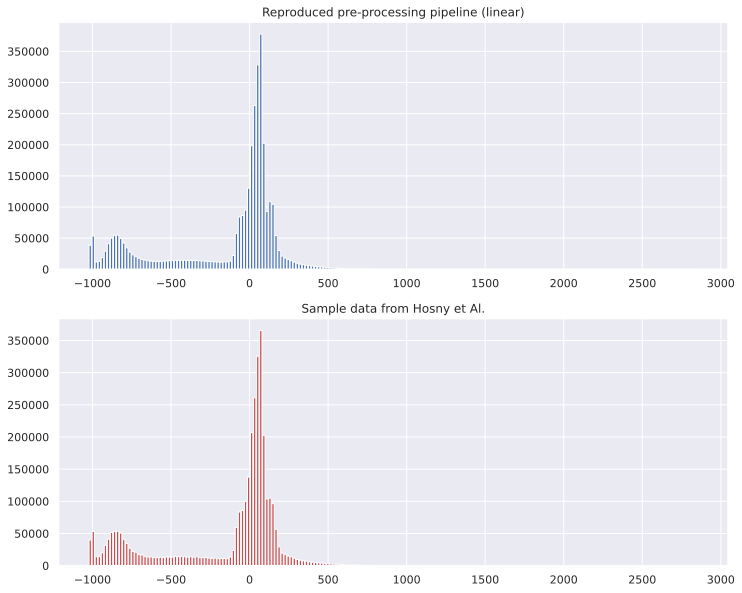

In [24]:
sns.set()
%matplotlib inline

fig, (ax_repr, ax_orig) = plt.subplots(2, 1, figsize = (12, 10))

hist, bins = np.histogram(ct_res_vol.flatten(), bins = 200)
bar_width = 0.75 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax_repr.bar(center, hist, width = bar_width, color = 'b')
ax_repr.set_title('Reproduced pre-processing pipeline (linear)')

hist, bins = np.histogram(sample_vol.flatten(), bins = 200)
bar_width = 0.75 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax_orig.bar(center, hist, width = bar_width, color = 'r')
ax_orig.set_title('Sample data from Hosny et Al.')

Text(0.5, 1.0, 'Sample data from Hosny et Al.')

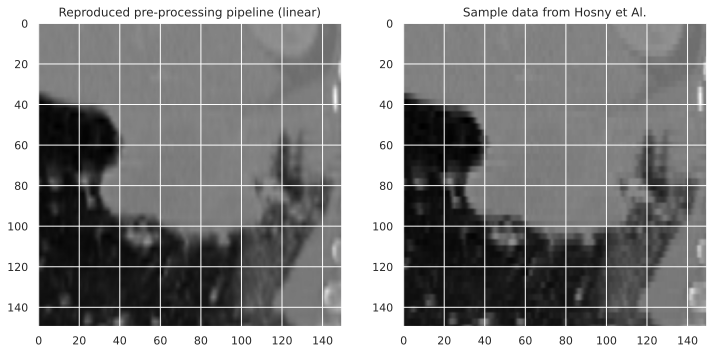

In [25]:
slice_num = 42*2

ct_res_vol_slice = ct_res_vol[:, :, slice_num]
sample_vol_slice = sample_vol[:, :, slice_num]


fig, (ax_repr, ax_orig) = plt.subplots(1, 2, figsize = (12, 8))

ax_repr.imshow(ct_res_vol_slice, cmap = 'gray',
               vmin = np.min(ct_res_vol_slice),
               vmax = np.max(ct_res_vol_slice))
ax_repr.set_title('Reproduced pre-processing pipeline (linear)')

ax_orig.imshow(sample_vol_slice, cmap = 'gray',
               vmin = np.min(ct_res_vol_slice),
               vmax = np.max(ct_res_vol_slice))
ax_orig.set_title('Sample data from Hosny et Al.')

---
---

# <center> Data Processing </center>


The network comprises a total of four 3D convolutional layers of an increasing number of filters, and two max pooling layers (after the second and fourth convolutional layers). The head of the model is a series of four fully connected layers which provide high-level reasoning before the prediction probabilities are calculated in the final softmax classifier layer. 

Additional details regarding the model development, architectural choices and training can be found in the PLOS Medicine paper.

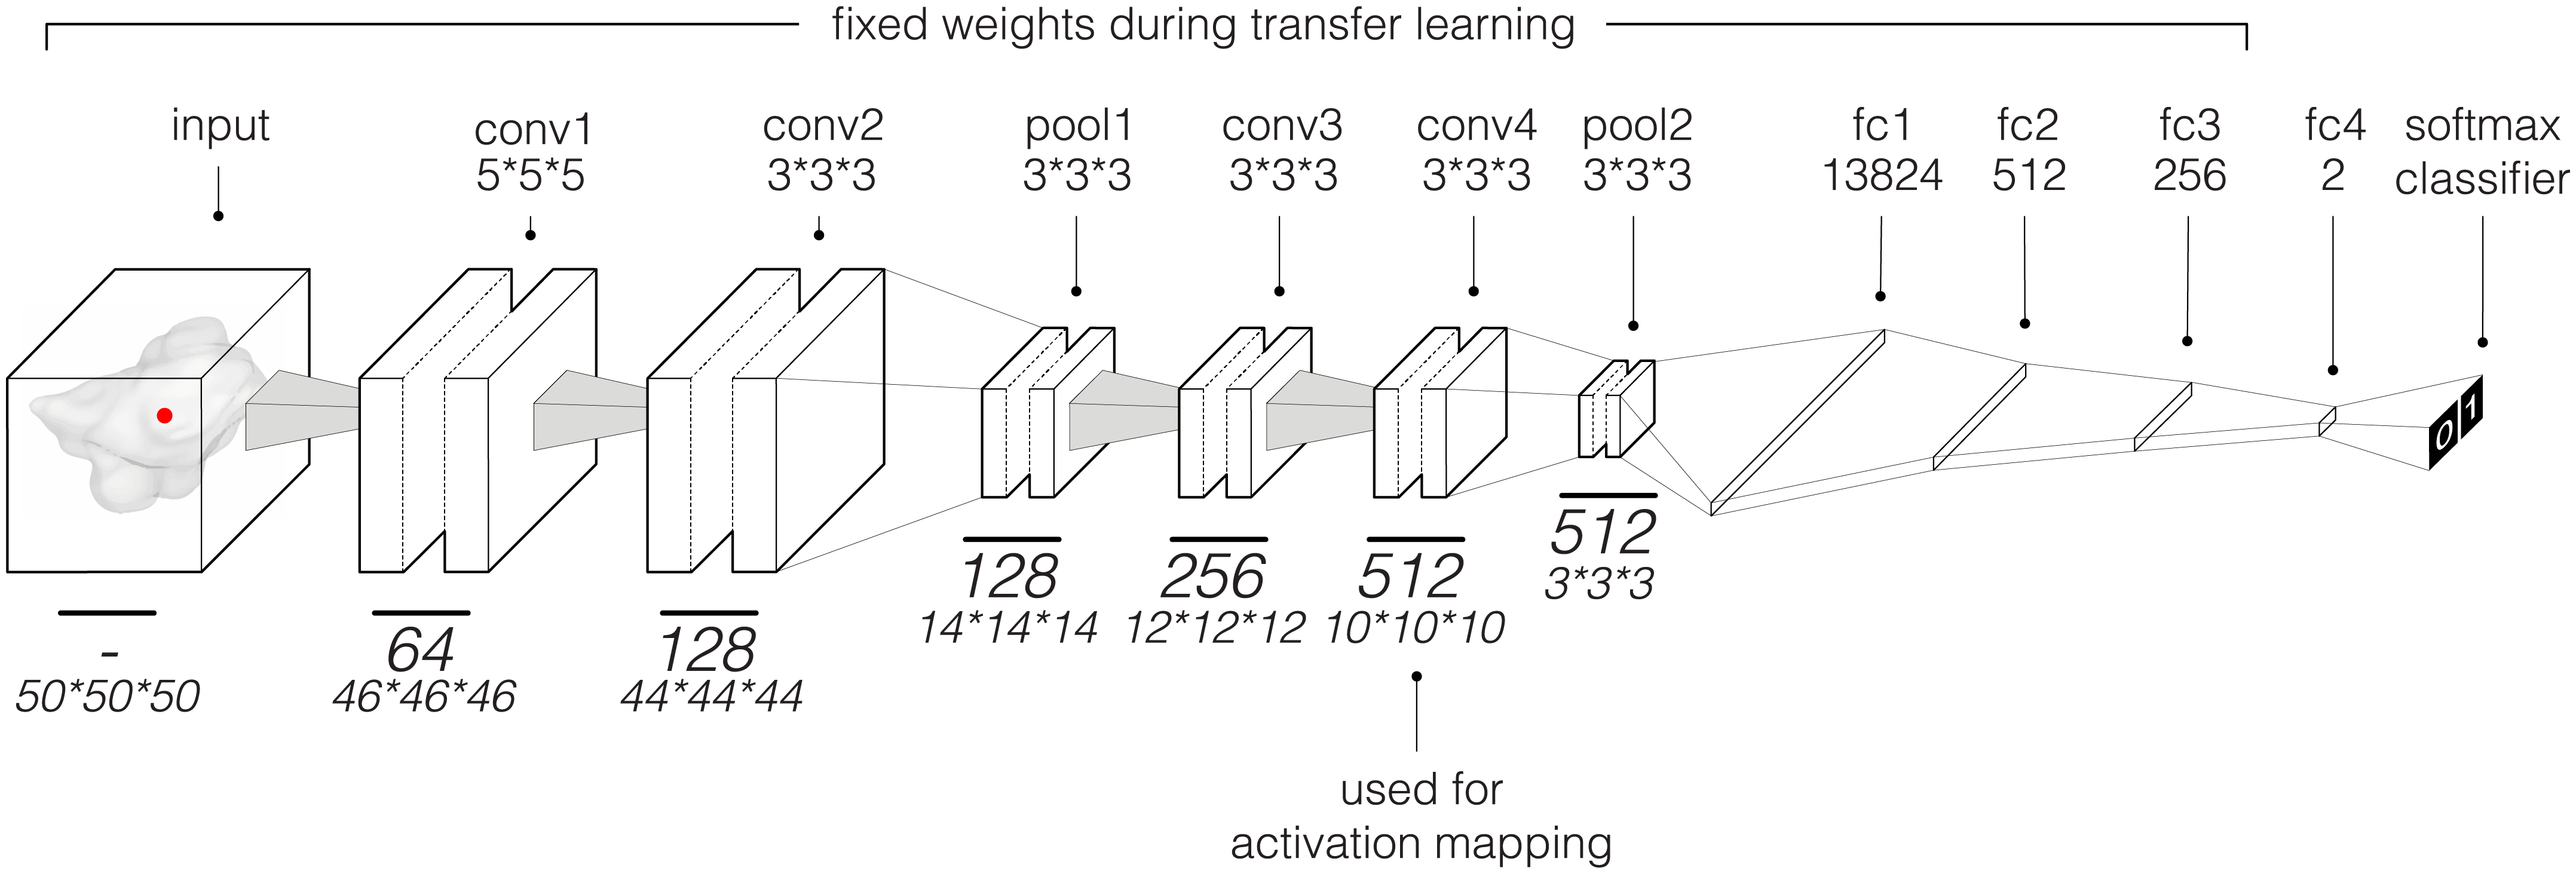

In [26]:
arch_json_path = "demo/architecture.json"
weights_path = "demo/weights.h5"

"""
 N.B. the warnings are due to the fact that the model was developed for
 Keras 1, and the config file has been converted in a Keras-2-compatible file

 Nonetheless, Keras 2 uses different naming conventions/def.s, so in order to
 get rid of the warnings one should change all the layers def.s in the JSON file
"""

# load the model architecture from the config file, then load the model weights 
with open(arch_json_path, 'r') as json_file:
    model_json = json.load(json_file)  

model = keras.models.model_from_config(model_json)
model.summary()

model.load_weights(weights_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/tensorflow-1.15.2/python3.6/keras/engine/base_layer.py:1179: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(name="convolution3d_1", activation="linear", trainable=True, input_dtype="float32", batch_input_shape=[None, 50,..., activity_regularizer={'class_na..., kernel_size=(5, 5, 5), filters=64, strides=[1, 1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
/tensorflow-1.15.2/python3.6/keras/engine/base_layer.py:1179: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(gamma_regularizer=None, name="batchnormalization_1", epsilon=0.001, trainable=True, beta_regularizer=None, momentum=0.99, axis=-1)`
  return cls(**config)
/tensorflow-1.15.2/python3.6/keras/engine/base_layer.py:1179: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(trainable

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution3d_1 (Conv3D)     (None, 46, 46, 46, 64)    8064      
_________________________________________________________________
batchnormalization_1 (BatchN (None, 46, 46, 46, 64)    256       
_________________________________________________________________
leakyrelu_1 (LeakyReLU)      (None, 46, 46, 46, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 46, 46, 64)    0         
_________________________________________________________________
convolution3d_2 (Conv3D)     (None, 44, 44, 44, 128)   221312    
_________________________________________________________________
batchnormalization_2 (BatchN (None, 44, 44, 44, 128)   512       
_________________________________________________________________
leakyrelu_2 (LeakyReLU)      (None, 44, 44, 44, 128)  

---

In [27]:
# define a new dataframe to store basics information + baseline output
# as well as the reproduced experiment output
df_keys = ['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID_CT',
           'SeriesInstanceUID_RTSTRUCT', 'CNN_output_raw', 'CNN_output_argmax',
           'baseline_output_raw', 'baseline_output_argmax', 'surv2yr'
           ]

data = {k : list() for k in df_keys}

out_df = pd.DataFrame(data, dtype = object)

In [28]:
y_pred_dict = dict()

input_df = pd.read_csv(dataset_csv_path) 
input_subj_list = list(input_df["PatientID"])

for idx, subj in enumerate(input_subj_list):

    print("Processing subject '%s' (%d/%d)... "%(subj, idx + 1, len(input_subj_list)), end = '\r')

    """
    The NRRD files for each subject in "input_df" should exist and readable
    (already double checked during the creation of 'lung1_proc_details.csv').
    If not, just run the code in  'lung1_det_csv.ipynb', found under /src.
    """
    
    subj_df = input_df[input_df['PatientID'] == subj]
    
    ct_res_crop_path = os.path.join(preproc_data_path, subj, subj + '_ct_res_crop.nrrd')
    
    input_vol = get_input_volume(input_ct_nrrd_path = ct_res_crop_path)
    input_vol = np.expand_dims(input_vol, axis = 0)
    input_vol = np.expand_dims(input_vol, axis = -1)
    
    y_pred_raw = model.predict(input_vol)
    y_pred_argmax = int(np.argmax(y_pred_raw[0]))
    
    subj_dict = dict()
    subj_dict["PatientID"] = subj
    
    subj_dict["StudyInstanceUID"] = subj_df["ctStudyInstanceUID"].values[0]
    subj_dict["SeriesInstanceUID_CT"] = subj_df["ctSeriesInstanceUID"].values[0]
    subj_dict["SeriesInstanceUID_RTSTRUCT"] = subj_df["rtstructSeriesInstanceUID"].values[0]

    subj_dict["CNN_output_raw"] = y_pred_raw.tolist()[0]
    subj_dict["CNN_output_argmax"] = y_pred_argmax
    
    baseline_output_list = list()
    
    try:
        baseline_output_list.append(baseline_df[baseline_df["id"] == ' %s'%(subj)]["logit_0"].values[0])
        baseline_output_list.append(baseline_df[baseline_df["id"] == ' %s'%(subj)]["logit_1"].values[0])

        subj_dict['baseline_output_raw'] = np.array(baseline_output_list)
        subj_dict['baseline_output_argmax'] = int(np.argmax(np.array(baseline_output_list)))
        
        subj_dict['surv2yr'] = baseline_df[baseline_df["id"] == ' %s'%(subj)]["surv2yr"].values[0]
    except:
        pass

    out_df = out_df.append(subj_dict, ignore_index = True)

In [29]:
out_df

,PatientID,StudyInstanceUID,SeriesInstanceUID_CT,SeriesInstanceUID_RTSTRUCT,CNN_output_raw,CNN_output_argmax,baseline_output_raw,baseline_output_argmax,surv2yr
0,LUNG1-002,1.3.6.1.4.1.32722.99.99.2037150038059966416957...,1.3.6.1.4.1.32722.99.99.2329880015517990803358...,1.3.6.1.4.1.40744.29.2432675512669112458302594...,"[0.9725281000137329, 0.02747190184891224]",0,"[0.9683470129999999, 0.03165298]",0,0
1,LUNG1-038,1.3.6.1.4.1.32722.99.99.2475020851376675459335...,1.3.6.1.4.1.32722.99.99.2650234890770352701645...,1.3.6.1.4.1.40744.29.1878428656637439964988662...,"[0.9744253754615784, 0.02557455189526081]",0,"[0.9202639459999999, 0.079736091]",0,0
2,LUNG1-055,1.3.6.1.4.1.32722.99.99.2284792753098082964616...,1.3.6.1.4.1.32722.99.99.5212730671773885988249...,1.3.6.1.4.1.40744.29.2203808798590393720861702...,"[0.9687211513519287, 0.031278785318136215]",0,"[0.9749287959999999, 0.025071179]",0,0
3,LUNG1-077,1.3.6.1.4.1.32722.99.99.3021236059167307643539...,1.3.6.1.4.1.32722.99.99.2008814152555682954343...,1.3.6.1.4.1.40744.29.8007440293870274493922761...,"[0.9648839235305786, 0.03511610999703407]",0,"[0.967235684, 0.032764282]",0,0
4,LUNG1-078,1.3.6.1.4.1.32722.99.99.1979963770295813468388...,1.3.6.1.4.1.32722.99.99.2086535154487063707444...,1.3.6.1.4.1.40744.29.1816843003193922537050254...,"[0.9539564847946167, 0.04604353755712509]",0,"[0.953973889, 0.046026155]",0,1
5,LUNG1-089,1.3.6.1.4.1.32722.99.99.1980045160315312426282...,1.3.6.1.4.1.32722.99.99.3163288809266658305716...,1.3.6.1.4.1.40744.29.1996955383018493136058970...,"[0.9331467747688293, 0.06685324758291245]",0,"[0.933094084, 0.066905983]",0,1
6,LUNG1-096,1.3.6.1.4.1.32722.99.99.4293513726905508119378...,1.3.6.1.4.1.32722.99.99.1755398672387103079081...,1.3.6.1.4.1.40744.29.2109938772966623030889237...,"[0.9803566336631775, 0.01964331977069378]",0,"[0.980237305, 0.01976268]",0,0
7,LUNG1-098,1.3.6.1.4.1.32722.99.99.1948418856560676328302...,1.3.6.1.4.1.32722.99.99.2038001733004493703319...,1.3.6.1.4.1.40744.29.5764650611154761683307406...,"[0.9396659135818481, 0.06033406779170036]",0,"[0.939527094, 0.06047290599999999]",0,0
8,LUNG1-101,1.3.6.1.4.1.32722.99.99.2181619283844400761797...,1.3.6.1.4.1.32722.99.99.4607783786930715275093...,1.3.6.1.4.1.40744.29.2945471959951889289167916...,"[0.9699001312255859, 0.030099833384156227]",0,"[0.96988982, 0.030110192999999997]",0,0
9,LUNG1-151,1.3.6.1.4.1.32722.99.99.1014458106504333912245...,1.3.6.1.4.1.32722.99.99.2174961270324077349300...,1.3.6.1.4.1.40744.29.2267145905245160823309116...,"[0.9710950255393982, 0.028904989361763]",0,"[0.97421366, 0.025786299]",0,0


---
---

# <center> Visualising the Results </center>


The results (in term of ROC AUC and PR PR) greatly vary based on the subcohort (randomly) selected.

The reproduced pipeline can yield results that are up to 10% better (or worse, depending on the selected patients) with respect to the original results. When the full cohort is analysed (that is, the sub-cohort which the authors analysed - which is a part of the NSCLC-Radiomics dataset), Hosny et Al. model shows a ROC AUC of $0.7$, whereas the IDC replicated pipeline reaches a ROC AUC of $0.68$.

In [33]:
# for some reasons, sklearn sometimes raises an error in Google Colab
# ("no module named sklearn.metrics") - this is a quick way to fix it
%%capture
sklearn.metrics

In [34]:
# replication
y_true = np.stack(out_df["surv2yr"].values)
y_pred = np.stack(out_df["CNN_output_raw"].values)

fpr, tpr, thr_roc = sklearn.metrics.roc_curve(y_true, y_pred[:, 1])
prc, rec, thr_pr = sklearn.metrics.precision_recall_curve(y_true, y_pred[:, 1])

roc_auc = sklearn.metrics.auc(fpr, tpr)
pr_auc = sklearn.metrics.auc(rec, prc)

print("ROC AUC: %g"%(roc_auc))
print("PR AUC: %g"%(pr_auc))

ROC AUC: 0.785714
PR AUC: 0.567727


In [35]:
# Hosny et Al. model
y_pred_baseline = np.stack(out_df["baseline_output_raw"].values)

fpr_base, tpr_base, thr_roc_base = sklearn.metrics.roc_curve(y_true, 
                                                             y_pred_baseline[:, 1])

prc_base, rec_base, thr_pr_base = sklearn.metrics.precision_recall_curve(y_true,
                                                                         y_pred_baseline[:, 1])

roc_auc_baseline = sklearn.metrics.auc(fpr_base, tpr_base)
pr_auc_baseline = sklearn.metrics.auc(rec_base, prc_base)

print("ROC AUC: %g"%(roc_auc_baseline))
print("PR AUC: %g"%(pr_auc_baseline))

ROC AUC: 0.738095
PR AUC: 0.507407


In [36]:
# operating point
opp = 0.5

opp_roc = np.argmin(np.abs(thr_roc - opp))
opp_pr = np.argmin(np.abs(thr_pr - opp))

print('ROC OPP: FPR = %2.4f, TPR = %2.4f'%(fpr[opp_roc], tpr[opp_roc]))
print('PR OPP: PRC = %2.4f, REC = %2.4f'%(prc[opp_pr], rec[opp_pr]))

# ----------------------------------------

opp_baseline = 0.5

opp_roc_baseline = np.argmin(np.abs(thr_roc_base - opp_baseline))
opp_pr_baseline = np.argmin(np.abs(thr_pr_base - opp_baseline))

print('\nROC OPP: FPR = %2.4f, TPR = %2.4f'%(fpr_base[opp_roc_baseline], tpr_base[opp_roc_baseline]))
print('PR OPP: PRC = %2.4f, REC = %2.4f'%(prc_base[opp_pr_baseline], rec_base[opp_pr_baseline]))

ROC OPP: FPR = 0.0000, TPR = 0.1429
PR OPP: PRC = 1.0000, REC = 0.1429

ROC OPP: FPR = 0.0000, TPR = 0.1429
PR OPP: PRC = 1.0000, REC = 0.1429


Text(0.5, 1.0, 'PR curve - replicated pre-processing pipeline')

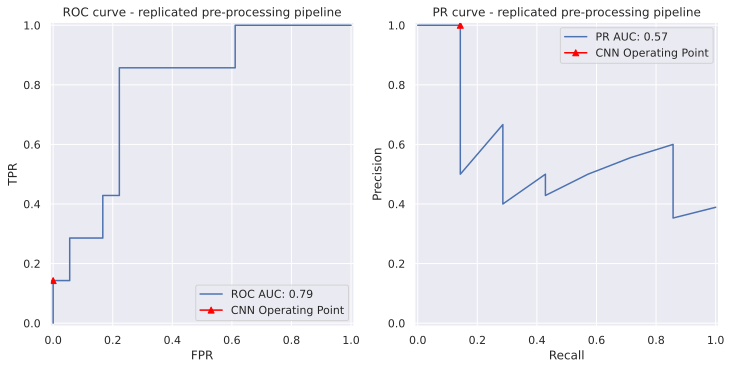

In [37]:
%matplotlib inline
sns.set()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 12))

# plot ROC curve
ax0.plot(fpr, tpr, label = 'ROC AUC: %2.2f'%(roc_auc))

# plot operating point on ROC curve
ax0.plot(fpr[opp_roc], tpr[opp_roc], label = 'CNN Operating Point', marker = '^', color = 'red')
ax0.legend(loc = 'lower right')
ax0.set_aspect('equal', 'box')
ax0.set_xlim([-0.01, 1.01])
ax0.set_ylim([-0.01, 1.01])
ax0.set_xlabel('FPR')
ax0.set_ylabel('TPR')
ax0.set_title('ROC curve - replicated pre-processing pipeline')

## ----------------------------------------

# plot PR curve
ax1.plot(rec, prc, label = 'PR AUC: %2.2f'%(pr_auc))

# plot operating point on PR curve
ax1.plot(rec[opp_pr], prc[opp_pr], label = 'CNN Operating Point', marker = '^', color = 'red')
ax1.legend(loc = 'upper right')
ax1.set_aspect('equal', 'box')
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR curve - replicated pre-processing pipeline')

Text(0.5, 1.0, 'PR curve - results from Hosny et Al.')

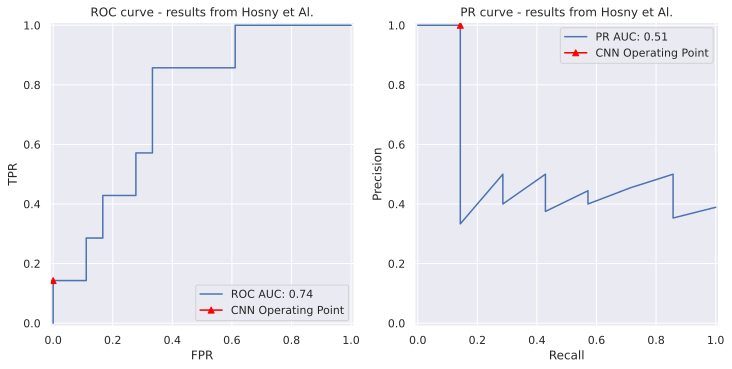

In [38]:
sns.set()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 12))

# plot ROC curve
ax0.plot(fpr_base, tpr_base, label = 'ROC AUC: %2.2f'%(roc_auc_baseline))

# plot operating point on ROC curve
ax0.plot(fpr_base[opp_roc_baseline], tpr_base[opp_roc_baseline],
         label = 'CNN Operating Point', marker = '^', color = 'red')
ax0.legend(loc = 'lower right')
ax0.set_aspect('equal', 'box')
ax0.set_xlim([-0.01, 1.01])
ax0.set_ylim([-0.01, 1.01])
ax0.set_xlabel('FPR')
ax0.set_ylabel('TPR')
ax0.set_title('ROC curve - results from Hosny et Al.')

## ----------------------------------------

# plot PR curve
ax1.plot(rec_base, prc_base, label = 'PR AUC: %2.2f'%(pr_auc_baseline))

# plot operating point on PR curve
ax1.plot(rec_base[opp_pr_baseline], prc_base[opp_pr_baseline],
         label = 'CNN Operating Point', marker = '^', color = 'red')
ax1.legend(loc = 'upper right')
ax1.set_aspect('equal', 'box')
ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR curve - results from Hosny et Al.')